In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import fiona

In [3]:
dfmg = pd.read_csv("dfmg.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [4]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_surfbot_vsTime as pltsurfbot

import plot_profiles_vs_dist as profDist

In [5]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [6]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [7]:
year_mask = []
years_df = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years_df)):
    mask = dfmg['JULD'].dt.year == years_df[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [9]:
def get_surf_salinity_yearly_mean(df, mask_region=Ross, years=[2010, 2011, 2012, 2014], save=False, 
                                  savename="Untitled.png", layer="Surface", var="PSAL_ADJUSTED"):
    def get_years(df, years=[2010]):
        mask_year = [None] * len(years)
        for i in range(len(years)):
            mask_year[i] = df.loc[:, 'JULD'].dt.year == years[i]
        return mask_year

    mask_years = get_years(df, years=years)
    if(layer=="Bottom250"):
        mask_layer = dfmg.loc[:, 'DEPTH'] <= -250
    elif(layer == "Bottom375"):
        mask_layer = dfmg.loc[:, 'DEPTH'] <= -375
    elif(layer == "Bottom500"):
        mask_layer = dfmg.loc[:, 'DEPTH'] <= -500
    elif(layer == "Surface"):
        mask_layer = dfmg.loc[:, 'DEPTH'] >= -100
    elif(layer == 'Whole'):
        mask_layer = dfmg.loc[:, 'DEPTH'] <= 0
    prop_yearly_mean = np.zeros(len(years))
    propError_yearly_mean = np.zeros(len(years))
    sd = np.zeros(len(years))
    sd_error = np.zeros(len(years))
    n = np.zeros(len(years))

    if(var == "PSAL_ADJUSTED"):
        varerror = "PSAL_ADJUSTED_ERROR"
    elif(var == "CTEMP"):
        varerror = "TEMP_ADJUSTED_ERROR"
    else:
        print("var can only be PSAL_ADJUSTED or CTEMP")
        return 0
    
    for i in range(len(years)):
        prop_yearly_mean[i] =  dfmg.loc[mask_region & mask_years[i] & mask_layer, var].mean()
        propError_yearly_mean[i] = dfmg.loc[mask_region & mask_years[i] & mask_layer, varerror].mean()
        sd[i] = dfmg.loc[mask_region & mask_years[i] & mask_layer, var].std()
        sd_error[i] = dfmg.loc[mask_region & mask_years[i] & mask_layer, varerror].std()
        
        n[i] = dfmg.loc[mask_region & mask_years[i] & mask_layer, var].count()
        
    fig, ax = plt.subplots(figsize=(7,4))
    yerr = np.sqrt(propError_yearly_mean**2 + 1.96**2 * (sd**2 + sd_error**2) / n )
    
    ax.errorbar(years, prop_yearly_mean, yerr=yerr, capsize=3, fmt="none")
    ax.scatter(years, prop_yearly_mean)
    
    z, res, _, _, _ = np.polyfit(years, prop_yearly_mean, 1, full=True)
    p = np.poly1d(z)
    
    ax.plot(years,p(years),"k--")
    ax.set_xlabel("Years")
    ax.set_ylabel("PSU")
    if(save==True):
        plt.savefig(savename)
    plt.show()
    print("y=%.6fx+(%.6f)"%(z[0],z[1]), "res=",res)
    return prop_yearly_mean, sd, n

### Ross Surface and Bottom salinity trend

In [44]:
shelfSeas = dfmg.ECHODEPTH > -1000

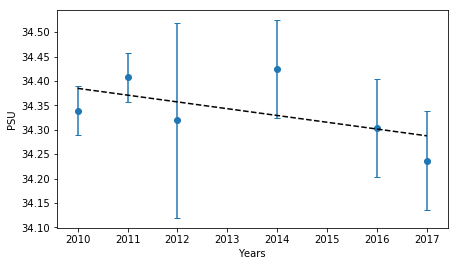

y=-0.013895x+(62.312933) res= [ 0.01646698]


(array([ 34.33902701,  34.40774371,  34.31933769,  34.42423036,
         34.30349319,  34.23689606]),
 array([ 0.31039146,  0.39359505,  0.37047469,  0.2582127 ,  0.32559803,
         0.26338177]),
 array([ 64121.,  49963.,  44316.,  13702.,   4867.,    584.]))

In [17]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, years=np.array([2010, 2011, 2012, 2014, 2016, 2017]), 
                              layer='Surface')

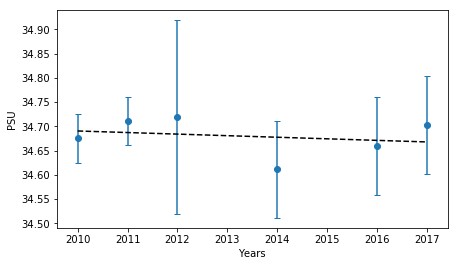

y=-0.003226x+(41.174336) res= [ 0.00771173]


(array([ 34.67503932,  34.71125404,  34.71856161,  34.61127474,
         34.65954006,  34.7021726 ]),
 array([ 0.08436901,  0.12967824,  0.1071263 ,  0.0792132 ,  0.06453836,
         0.03639717]),
 array([ 18632.,  11122.,   7566.,   3782.,    880.,     39.]))

In [18]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, 
                              years=np.array([ 2010, 2011, 2012, 2014, 2016, 2017]), layer="Bottom250")

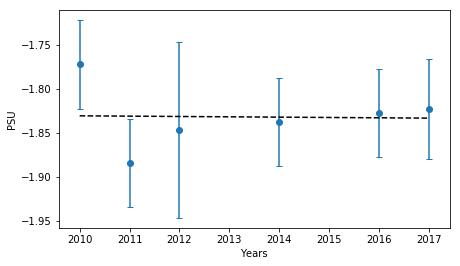

y=-0.000375x+(-1.077655) res= [ 0.0066671]


(array([-1.77224398, -1.88440658, -1.84649629, -1.83794663, -1.82742738,
        -1.82256012]),
 array([ 0.30418393,  0.25617506,  0.1266263 ,  0.10181854,  0.08858502,
         0.08654198]),
 array([ 18631.,  11122.,   7566.,   3782.,    880.,     39.]))

In [35]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, var="CTEMP",
                              years=np.array([ 2010, 2011, 2012, 2014, 2016, 2017]), layer="Bottom250")

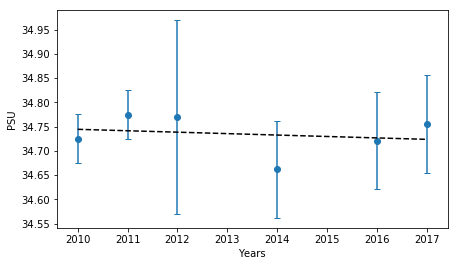

y=-0.002957x+(40.688161) res= [ 0.00845963]


(array([ 34.72523457,  34.77458659,  34.76913582,  34.66186582,
         34.72077787,  34.75564575]),
 array([ 0.06150591,  0.14144454,  0.08990939,  0.06611553,  0.05267247,
         0.00616086]),
 array([  7.46700000e+03,   3.58400000e+03,   3.14400000e+03,
          1.20200000e+03,   2.21000000e+02,   2.00000000e+00]))

In [36]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, 
                              years=np.array([2010, 2011, 2012, 2014, 2016, 2017]), layer="Bottom375")

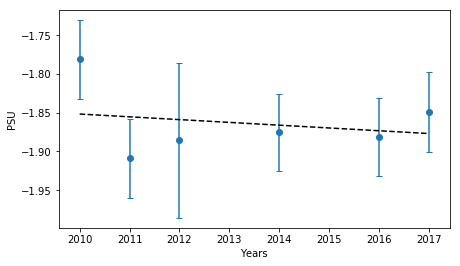

y=-0.003599x+(5.382280) res= [ 0.00950889]


(array([-1.78115318, -1.90883555, -1.88579254, -1.87538696, -1.8816423 ,
        -1.8488468 ]),
 array([ 0.36390765,  0.34919083,  0.02958608,  0.07520096,  0.03445604,
         0.00856843]),
 array([  7.46600000e+03,   3.58400000e+03,   3.14400000e+03,
          1.20200000e+03,   2.21000000e+02,   2.00000000e+00]))

In [37]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, var='CTEMP',
                              years=np.array([2010, 2011, 2012, 2014, 2016, 2017]), layer="Bottom375")

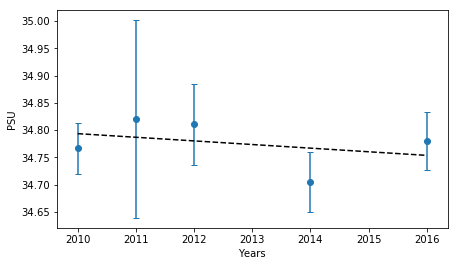

y=-0.006644x+(48.147068) res= [ 0.00737763]


(array([ 34.76637877,  34.82011661,  34.81036017,  34.70410916,  34.77973615]),
 array([ 0.04640108,  0.18120355,  0.07409111,  0.05495055,  0.05253745]),
 array([ 1263.,   642.,   652.,   255.,    13.]))

In [21]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Ross, 
                              years=np.array([2010, 2011, 2012, 2014, 2016]), layer="Bottom500")

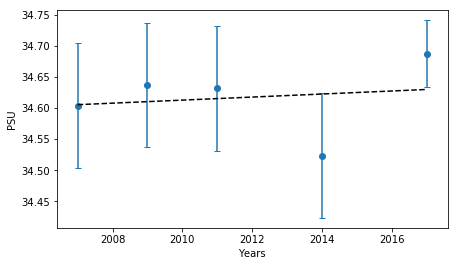

y=0.002447x+(29.694490) res= [ 0.0141058]


(array([ 34.60388129,  34.63708455,  34.63146227,  34.52343372,  34.68732465]),
 array([ 0.07452152,  0.0780361 ,  0.1028638 ,  0.03689025,  0.05522342]),
 array([  424.,   459.,  2137.,   693.,    30.]))

In [20]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Weddell & ~gline_le_75km, 
                              years=np.array([2007, 2009, 2011, 2014, 2017]), layer="Bottom500")

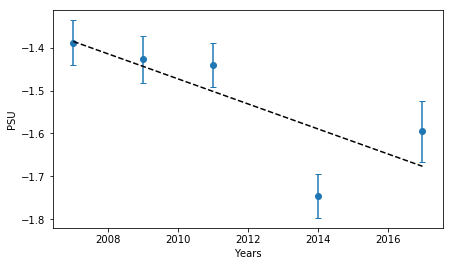

y=-0.029129x+(57.075870) res= [ 0.03519516]


(array([-1.38829033, -1.42739267, -1.44005816, -1.74557484, -1.59498898]),
 array([ 0.47444144,  0.54916948,  0.60085961,  0.30090504,  0.47309545]),
 array([ 3465.,  2012.,  9680.,  2480.,   328.]))

In [50]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Weddell & shelfSeas & ~gline_le_75km, var='CTEMP',
                              years=np.array([2007, 2009, 2011, 2014, 2017]), layer="Bottom375")

In [44]:
np.sort(dfmg.loc[gline_le_75km, "JULD"].dt.year.unique())

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

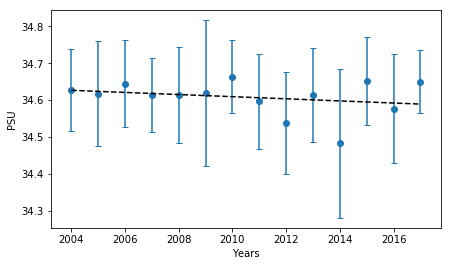

y=-0.002878x+(40.394936) res= [ 0.02875758]


(array([ 34.62644686,  34.61759565,  34.64494629,  34.61371491,
         34.61383711,  34.61940346,  34.66356088,  34.59708693,
         34.53749195,  34.61429238,  34.48247506,  34.65186511,
         34.57665964,  34.65005794]),
 array([ 0.11152238,  0.14298665,  0.11884151,  0.10165257,  0.12950527,
         0.19723823,  0.09987811,  0.12902333,  0.13878358,  0.1275008 ,
         0.20224998,  0.12065096,  0.14718709,  0.0855859 ]),
 array([  4830.,   3949.,   3191.,  26338.,  41315.,  37173.,  40119.,
         44115.,  47197.,  13739.,  46184.,   5754.,   5345.,   5546.]))

In [48]:
monthFeb = dfmg.JULD.dt.month == 2
monthMar = dfmg.JULD.dt.month == 3
get_surf_salinity_yearly_mean(dfmg, mask_region=[True]*len(dfmg), 
                              years=np.array([ 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017]), layer="Bottom375")

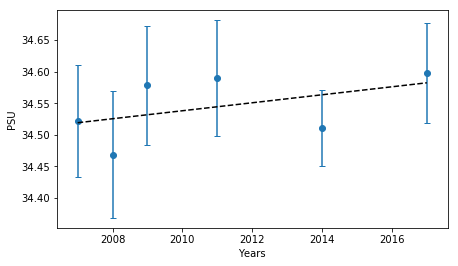

y=0.006327x+(21.819732) res= [ 0.01046047]


(array([ 34.52179466,  34.46842463,  34.57815565,  34.58935277,
         34.51048192,  34.59759196]),
 array([ 0.08943715,  0.10027697,  0.0948198 ,  0.09204363,  0.05979406,
         0.07884395]),
 array([  3585.,     34.,   2796.,  15866.,   2841.,    408.]))

In [49]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Weddell, 
                              years=np.array([2007, 2008, 2009, 2011, 2014, 2017]), layer="Bottom375")

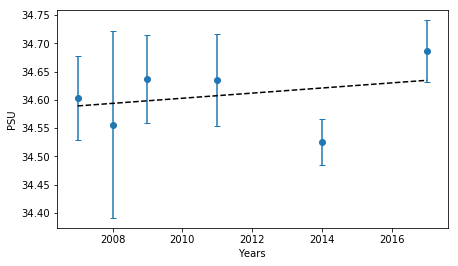

y=0.004530x+(25.497957) res= [ 0.01558029]


(array([ 34.60388129,  34.55607096,  34.63708455,  34.63538026,
         34.52597136,  34.68586633]),
 array([ 0.07452152,  0.16484126,  0.0780361 ,  0.0809668 ,  0.04046289,
         0.05489899]),
 array([  4.24000000e+02,   3.00000000e+00,   4.59000000e+02,
          3.63100000e+03,   7.42000000e+02,   3.10000000e+01]))

In [24]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Weddell, 
                              years=np.array([2007, 2008, 2009, 2011, 2014, 2017]), layer="Bottom500")

In [25]:
np.sort(dfmg.loc[WPB, "JULD"].dt.year.unique())

array([2004, 2005, 2007, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

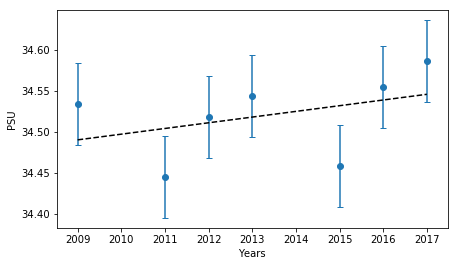

y=0.006965x+(20.497710) res= [ 0.01348705]


(array([ 34.53399107,  34.44475375,  34.51825242,  34.54347012,
         34.45824066,  34.5553198 ,  34.58641919]),
 array([ 0.07129789,  0.07232585,  0.07104631,  0.09123809,  0.05290922,
         0.0636791 ,  0.06104078]),
 array([   353.,  13349.,   7734.,   2090.,    588.,    659.,   1376.]))

In [55]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB, var="PSAL_ADJUSTED",
                              years=[ 2009, 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom250")

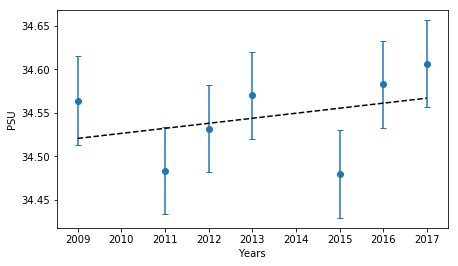

y=0.005791x+(22.886781) res= [ 0.01277581]


(array([ 34.56429855,  34.4836187 ,  34.53176081,  34.57028743,
         34.47962854,  34.58280076,  34.6064684 ]),
 array([ 0.07491242,  0.06101462,  0.06303508,  0.06398818,  0.04833581,
         0.06005139,  0.05547817]),
 array([  202.,  5548.,  4071.,   668.,   306.,   351.,   821.]))

In [56]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB, var="PSAL_ADJUSTED",
                              years=[ 2009, 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom375")

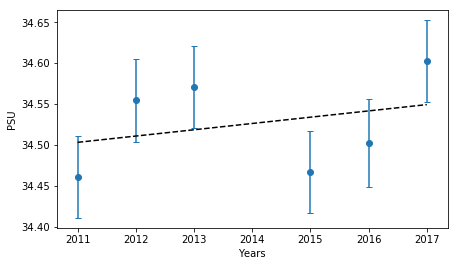

y=0.007678x+(19.062043) res= [ 0.01531308]


(array([ 34.46098516,  34.55444827,  34.57112028,  34.46652863,
         34.50246639,  34.60216845]),
 array([ 0.03638895,  0.06853608,  0.05661157,  0.02244106,  0.04329475,
         0.03492649]),
 array([ 1962.,  1031.,   434.,   169.,    20.,   259.]))

In [63]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB & shelfSeas & gline_le_75km, var="PSAL_ADJUSTED",
                              years=[ 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom375")

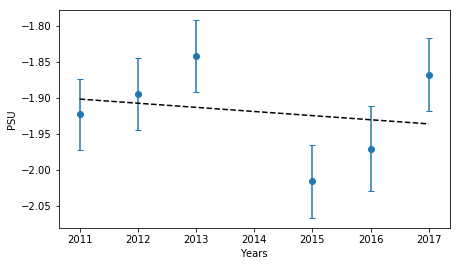

y=-0.005754x+(9.670651) res= [ 0.02033804]


(array([-1.92295901, -1.89386591, -1.84201684, -2.01590488, -1.97054909,
        -1.86758242]),
 array([ 0.05364584,  0.03068178,  0.05058707,  0.06913599,  0.07009749,
         0.05162035]),
 array([ 1962.,  1031.,   434.,   169.,    20.,   259.]))

In [60]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB & shelfSeas & gline_le_75km, var="CTEMP",
                              years=[ 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom375")

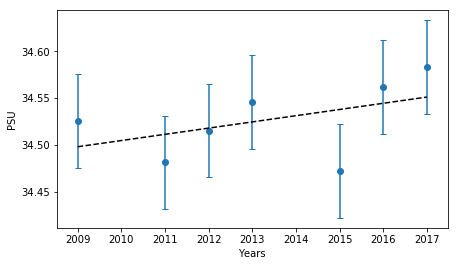

y=0.006650x+(21.138874) res= [ 0.00779423]


(array([ 34.52568035,  34.48133789,  34.51532717,  34.54586163,
         34.47196145,  34.56190874,  34.58317118]),
 array([ 0.04591195,  0.04983122,  0.0491233 ,  0.05005622,  0.02380909,
         0.03476433,  0.04983217]),
 array([  142.,  3237.,  2775.,   197.,   116.,   233.,   388.]))

In [64]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB & shelfSeas & ~gline_le_75km, var="PSAL_ADJUSTED",
                              years=[2009, 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom375")

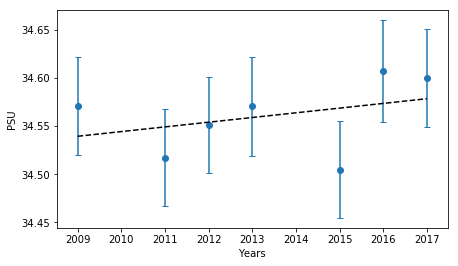

y=0.004875x+(24.745065) res= [ 0.00781655]


(array([ 34.57103194,  34.51727126,  34.55129567,  34.5703381 ,
         34.50488071,  34.60698877,  34.60019647]),
 array([ 0.0359703 ,  0.04765592,  0.04725264,  0.03995425,  0.01471776,
         0.04690279,  0.04879981]),
 array([  57.,  995.,  700.,   59.,   29.,   28.,   83.]))

In [65]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB & shelfSeas & ~gline_le_75km, var="PSAL_ADJUSTED",
                              years=[2009, 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom500")

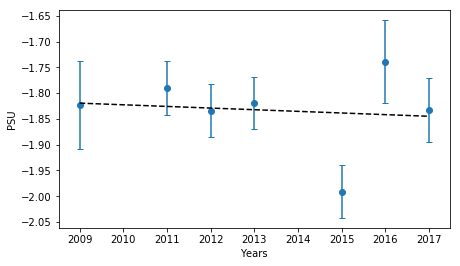

y=-0.003182x+(4.573343) res= [ 0.03536903]


(array([-1.82318054, -1.79085664, -1.83458876, -1.81953639, -1.99119709,
        -1.73926101, -1.8330835 ]),
 array([ 0.41788472,  0.45845307,  0.31994351,  0.03488065,  0.05142312,
         0.49218418,  0.37940423]),
 array([  142.,  3237.,  2775.,   197.,   116.,   233.,   388.]))

In [62]:
get_surf_salinity_yearly_mean(dfmg, mask_region=WPB & shelfSeas & ~gline_le_75km, var="CTEMP",
                              years=[2009, 2011, 2012, 2013, 2015, 2016, 2017], layer="Bottom375")

In [345]:
ICE = xr.open_dataset("/media/data/Datasets/SeaIce/HadISST/HadISST_ice.nc")

In [368]:
def get_seaIceConc(ICE, timemin, timemax, latmin, latmax, lonmin, lonmax):
    timeStart = np.asscalar(np.argmin(np.abs(ICE['time'] - timemin)).values)
    timeEnd = np.asscalar(np.argmin(np.abs(ICE['time'] - timemax)).values)
    
    latStart = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmax)).values)
    latEnd = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmin)).values)
    
    lonStart = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmin)).values)
    lonEnd = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmax)).values)
    
    return timeStart, timeEnd, latStart, latEnd, lonStart, lonEnd

In [373]:
time = np.arange('2006-02', '2006-10', dtype='datetime64[M]')
latmin = -90
latmax = -60
lonmin = -70
lonmax = -11

timeS, timeE, latS, latE, lonS, lonE = get_seaIceConc(ICE, time[0], time[-1], latmin, latmax, lonmin, lonmax)

In [492]:
import cartopy.crs as ccrs

In [493]:
sic = ICE.sic

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


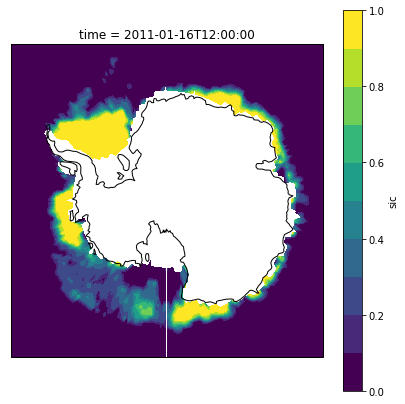

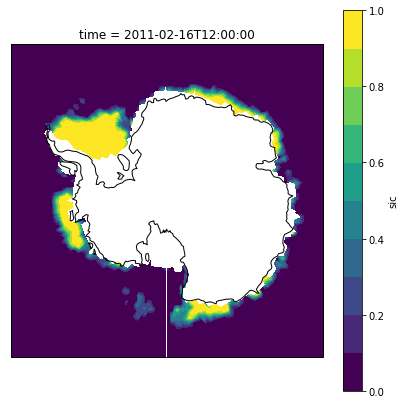

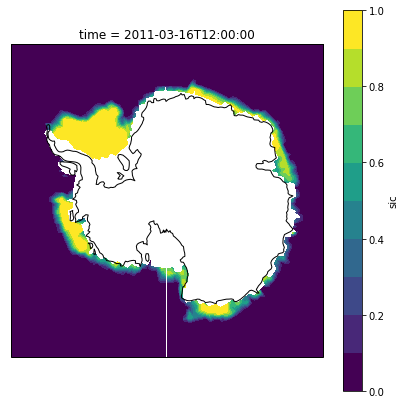

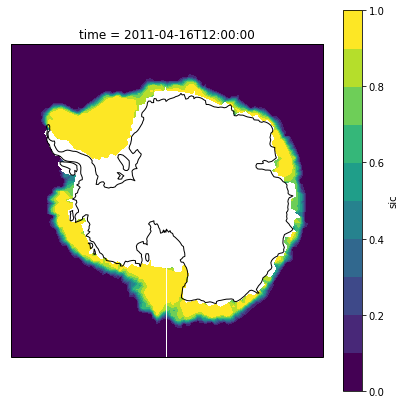

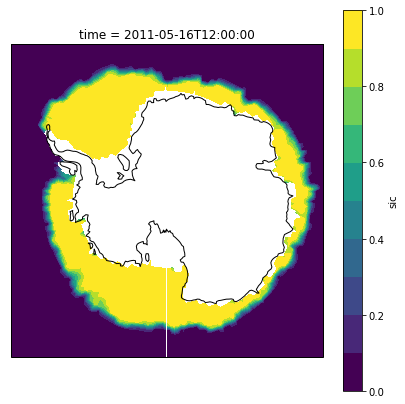

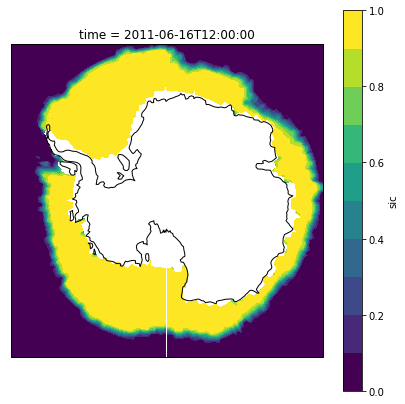

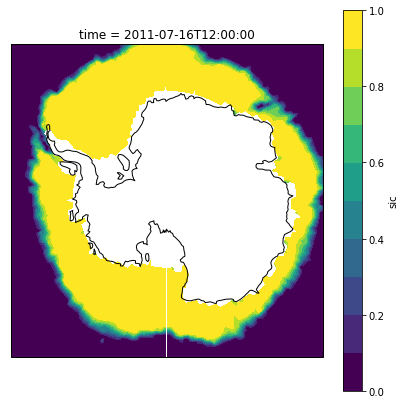

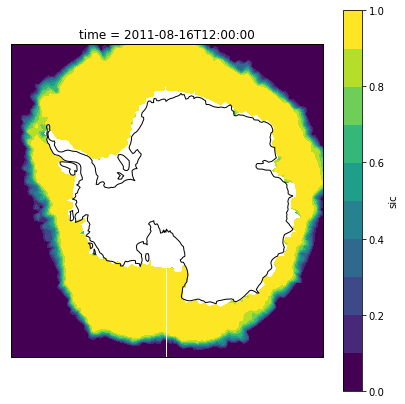

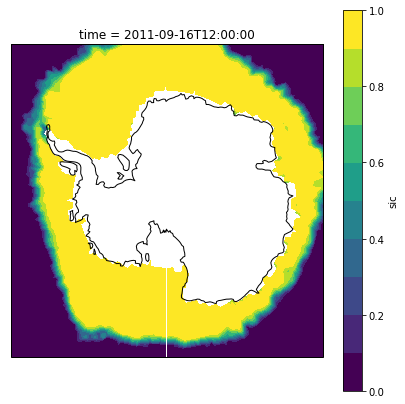

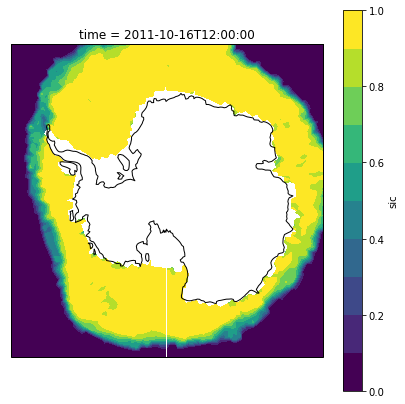

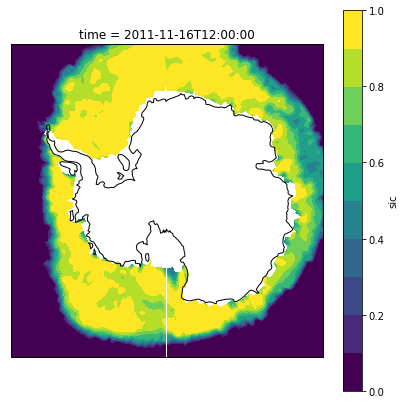

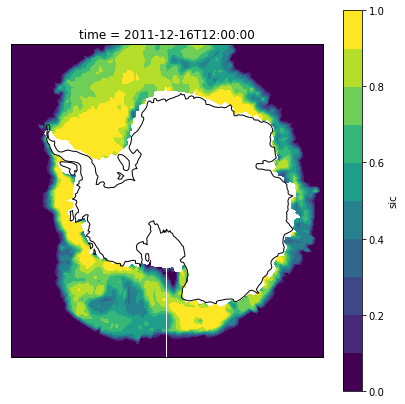

In [541]:
importlib.reload(topView)
time = np.arange('2011-02', '2012-02', dtype='datetime64[M]')
for i in range(len(time)):
    timeind = np.asscalar(np.argmin(np.abs(ICE['time'] - time[i])).values)
    topView.plotSeaIceConc(ICE, timeind, show=False, save=True, 
                           savename="./Images/SIC/2011_"+str(month_names[i])+".png")

In [542]:
for i in range(1,10,1):
    topView.plotDataDensity(dfmg.loc[Weddell & deep_mask & year_mask[7] & month_mask[i]], save=True, 
            savename="./Images/dataDensityWeddell2011Monthwise/dataDensityWeddell2011"+str(month_names[i])+".png", 
            wd=10, ht=10, nx=300, ny=300, region='Weddell', levels=[0,10,20,30,40,50])

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [7]:
import find_depth_averages_v2
importlib.reload(find_depth_averages_v2)

<module 'find_depth_averages_v2' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/find_depth_averages_v2.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


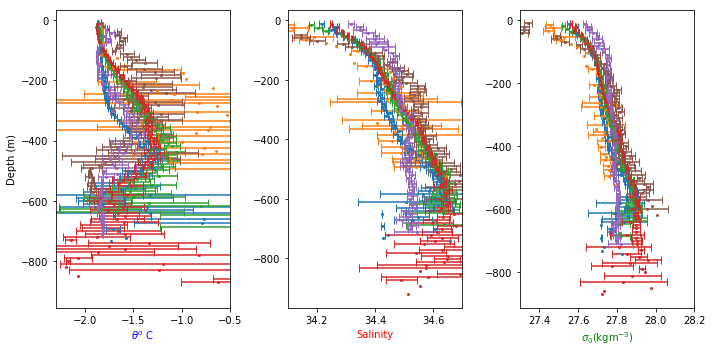

In [8]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Weddell & (~gline_le_100km), 
                                                    years=[2007, 2008, 2009, 2011, 2014, 2017], 
                                                    sigmin=27.3, 
                                                    sigmax=28.2, salmin=34.1, salmax=34.7, wd=10, min_n=0)

In [185]:
def get_surf_salinity_yearly_mean(df, mask_region=Ross, years=[2010, 2011, 2012, 2014], save=False, 
                                  savename="Untitled.png", layer="Surface"):
    
    if(layer=="Bottom"):
        mask_layer = dfmg.loc[:, 'DEPTH'] < -250
    elif(layer == "Surface"):
        mask_layer = dfmg.loc[:, 'DEPTH'] > -100
    surf_sal_regional_yearly_mean = np.zeros(len(years))
    sd = np.zeros(len(years))
    n = np.zeros(len(years))
    for i in range(len(years)):
        year_mask = dfmg.JULD.dt.year.isin([years[i]])
        surf_sal_regional_yearly_mean[i] =  dfmg.loc[mask_region & year_mask & mask_layer, \
                                                     'PSAL_ADJUSTED'].mean()
        sd[i] = dfmg.loc[mask_region & year_mask & mask_layer, \
                                                     'PSAL_ADJUSTED'].std()
        n[i] = dfmg.loc[mask_region & year_mask & mask_layer, \
                                                     'PSAL_ADJUSTED'].count()
        
    fig, ax = plt.subplots(figsize=(7,4))
    yerr = sd
    ax.errorbar(years, surf_sal_regional_yearly_mean, yerr=yerr, capsize=3, fmt=".")
    #ax.scatter(years, surf_sal_regional_yearly_mean)
    
    z, res, _, _, _ = np.polyfit(years, surf_sal_regional_yearly_mean, 1, full=True)
    p = np.poly1d(z)
    
    ax.plot(years,p(years),"k--")
    ax.set_xlabel("Years")
    ax.set_ylabel("PSU")
    if(save==True):
        plt.savefig(savename)
    plt.show()
    print("y=%.6fx+(%.6f)"%(z[0],z[1]), "res=",res)
    return surf_sal_regional_yearly_mean, sd, n

In [166]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PROFILE_NUMBER', 'PSAL_ADJUSTED',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'DEPTH',
       'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP', 'DENSITY_GRADIENT',
       'ECHODEPTH', 'mab', 'deep_flag', 'DIST_GLINE', 'SA'],
      dtype='object')

In [182]:
yearmask = dfmg.JULD.dt.year == 2014
len(dfmg.loc[Weddell & yearmask])

24859

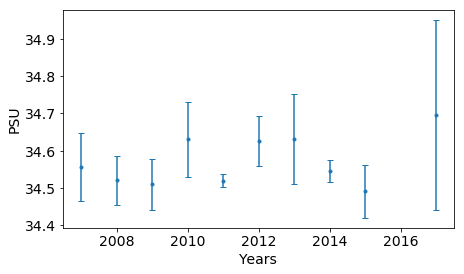

y=nanx+(9.975385) res= []


(array([         nan,  34.5557488 ,  34.51989812,  34.50926766,
         34.63031124,  34.51964922,  34.62579857,  34.63103754,
         34.54549569,  34.49057961,  34.69512759,          nan]),
 array([        nan,  0.09171919,  0.06478087,  0.0679679 ,  0.10015961,
         0.01666424,  0.06773499,  0.12130809,  0.02929519,  0.07133618,
         0.25549359,         nan]),
 array([    0.,  1730.,  1252.,   832.,  2650.,   282.,   156.,   870.,
          178.,    26.,    19.,     0.]))

In [187]:
get_surf_salinity_yearly_mean(dfmg, mask_region=Adelie, years=np.array([2005, 2007, 2008, 2009, 2010, 2011, 2012, 
                                                                        2013, 2014, 2015, 2017,2018]), layer="Bottom")

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
0 3


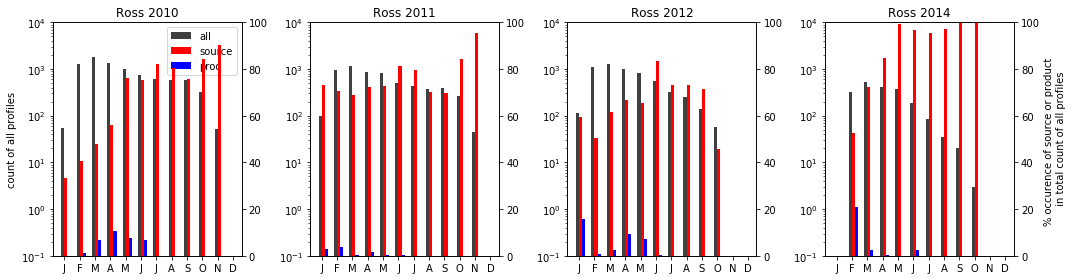

In [58]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[Ross&year_mask[6], Ross&year_mask[7], Ross&year_mask[8], Ross&year_mask[10]], 
                             row=1, col=4, titles=['Ross 2010','Ross 2011', 'Ross 2012', 'Ross 2014'], ht=4, wd=15)

In [289]:
print(np.mean(area_Ross_le75), np.average(area_Ross_Xle75), np.mean(area_Weddell_le75), np.mean(area_Weddell_Xle75)
     , np.mean(area_Prydz_le75), np.mean(area_Prydz_Xle75) )

32795.9291523 52893.4345169 3466.23641447 96021.41452 21047.387459 46894.1791842


In [54]:
!mkdir ./Images/seasonal

In [10]:
import plot_freshwater_vs_years as pltfh

In [11]:
salrange = list(np.arange(33.5, 35.05, 0.01))
salrange_disc = list(np.arange(33.5, 35.05, 0.1))
thetarange = [-2.5, -1.8, -1.3, -0.5, 0., 0.5, 1., 1.5] #list(np.arange(-3, 1, 0.01))
thetarange_disc = list(np.linspace(-3, 1, 10))
RossYears = [2010, 2011, 2012, 2014]
WeddellYears= [2007, 2009, 2011]
PrydzYears = [2011, 2012, 2013, 2015]

In [12]:
import plot_Profiles_vs_time as profile2dTime
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_Profiles_vs_time.py'>

In [ ]:
dfmg.D

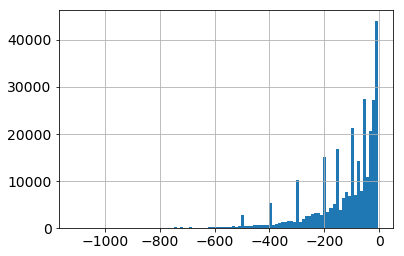

In [533]:
dfmg.loc[Ross, 'DEPTH'].hist(bins=100)
plt.show()

In [11]:
salrange_disc = list(np.arange(34, 35, 0.1))

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_Profiles_vs_time.py:50: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


160 180 -78 -72


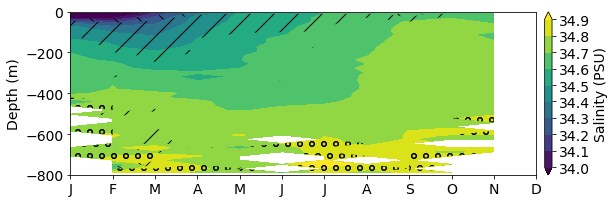

In [12]:
Rossle75_fh_m, depth_bins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&gline_le_75km], 
                                          years=[], depth_max=-800.0, zbin=20, 
                                          levs=salrange_disc, save=True, clim=True,
                                         savename="./Images/seasonal/RSA1_sal.png", type=0, wd=10, 
                                                                      ht=3, lonmin=160, lonmax=180)

In [540]:
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

In [58]:
len(thetarange_disc)

10

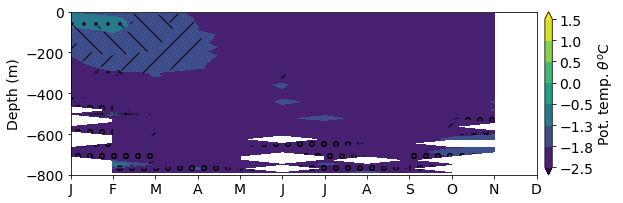

In [57]:
profile2dTime.plot_CT_contours_with_time(dfmg[Ross&gline_le_75km], 
                                          years=[], depth_max=-800, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/RSA1_CT.png", 
                                         wd=10, ht=3, show_legend=False)

In [27]:
Rossle75_fh_m[1]

[array([-192.90750292]), array([ 58.47791098])]

In [543]:
Rossle75_fh_m[2]

[array([ 129.67427834]), array([ 150.70361546])]

In [544]:
np.nansum(Rossle75_fh[0][0][0, ::-1][0:6]) + Rossle75_fh_m[1][0] - Rossle75_fh_m[2][0]

NameError: name 'Rossle75_f_h' is not defined

In [454]:
Rossle75_f_h[0][0][3, ::-1][0:6].sum()

1331.1561016117271

In [97]:
importlib.reload(pltfh)

<module 'plot_freshwater_vs_years' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_freshwater_vs_years.py'>

In [59]:
!mkdir ./Images/freshwaterFluxes

1992.61453184 [-192.90750292] [ 129.67427834]


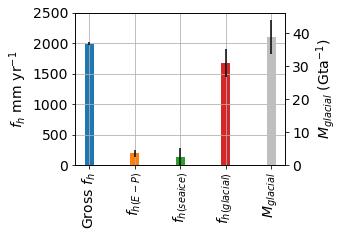

[ 225.9099347]


array([ 1670.03275058])

In [34]:
pltfh.print_climatological_fh(Rossle75_fh_m, np.mean(RSA1_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/RSA1.png', wd=5, ht=3.5)

In [186]:
print_yearly_fh(Rossle75_f_h, [2010, 2011, 2012, 2014])

2010 2339.27719124
2011 2307.73308612
2012 2575.81572075
2014 1117.67270496


In [183]:
Rossle75_f_h[0, ::-1][0:6].sum() * 1e-3 * area_Ross_le75 * 1030.0 * 1e-12

0.00014926376687407006

In [13]:
m = topView.createMapProjections(-90, 0, region="Whole")

In [14]:
Ross_years = [2010, 2011, 2012, 2014, 2016, 2017]
RSA1_area = topView.find_area(dfmg[Ross&gline_le_75km], m, years=Ross_years)

In [32]:
RSA2_area = topView.find_area(dfmg[Ross & ~gline_le_75km], m, years=Ross_years)

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:513: UserWarning: Warning: converting a masked element to nan.
  area[j] = cell_size_x * cell_size_y * number_of_cells


In [64]:
Weddell_years = [2007, 2008, 2009, 2011, 2014, 2017]
WSA1_area = topView.find_area(dfmg[Weddell & gline_le_75km], m, years=Weddell_years)

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:469: UserWarning: Warning: converting a masked element to nan.
  


In [65]:
WSA2_area = topView.find_area(dfmg[Weddell & ~gline_le_75km], m, years=Weddell_years)

In [66]:
WPB_years = [2005, 2007, 2009, 2011, 2012, 2013, 2015, 2016, 2017]
WPBA1_area = topView.find_area(dfmg[WPB & gline_le_75km], m, years=[])

In [68]:
WPBA2_area = topView.find_area(dfmg[WPB & ~gline_le_75km], m, years=[])

In [69]:
EPBA1_area = topView.find_area(dfmg[EPB & gline_le_75km], m, years=[])

In [70]:
EPBA2_area = topView.find_area(dfmg[EPB & ~gline_le_75km], m, years=[])

In [49]:
print(area_Ross_le75, area_Ross_Xle75, area_Weddell_le75, area_Weddell_Xle75 , area_Prydz_le75, area_Prydz_Xle75)

[ 43094.65080679  40994.91144034  30596.20219693  16497.95216501] [ 91388.65623529  49493.85649504  52493.48416141  18197.74117595] [ 1099.86347767            nan  9298.84576573] [  57192.90083871   46694.20400643  184177.13871488] [ 37695.32100733  25596.82275299   5699.2925661   15198.11350959] [ 92188.55694632  75790.59237018  11498.57272107   8098.99469919]


160 180 -77 -72


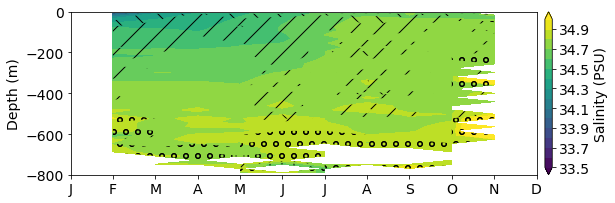

In [73]:
RossXle75_fh_m, dbins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&~gline_le_75km], 
                                          years=[], depth_max=-800, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/RSA2_sal.png", wd=10, ht=3, 
                                                                  lonmin=160, lonmax=180)

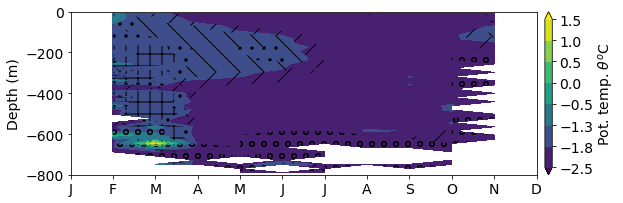

In [576]:
profile2dTime.plot_CT_contours_with_time(dfmg[Ross & ~gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-800, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/RossSal_XGLle75km_CT.png", wd=10, ht=3)

In [105]:
importlib.reload(pltfh)

<module 'plot_freshwater_vs_years' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_freshwater_vs_years.py'>

In [95]:
np.nanmean(RSA2_area)

41934.794775798291

1407.15259094 [-231.77181019] [ 134.59851655]


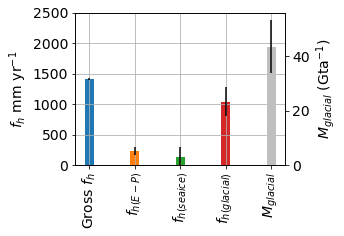

[ 234.75074826]


array([ 1040.78226421])

In [106]:
pltfh.print_climatological_fh(RossXle75_fh_m, np.nanmean(RSA2_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/RSA2.png', wd=5, ht=3.5)

2010 1557.56479467 0.0 152.936979856
2011 1914.79223511 -113.813588108 114.555701857
2012 2441.90317863 0.0 146.458540098
2014 754.275882099 -125.989656924 125.101295769


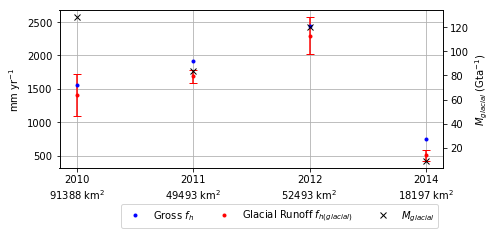

[ 310.45223195   97.98674751  273.95087731   79.54373995]


array([ 1404.62781482,  1686.42294515,  2295.44463853,   503.18492941])

In [70]:
pltfh.print_yearly_fh(RossXle75_fh_m, [2010, 2011, 2012, 2014], area_Ross_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Ross_X_le75_mass.png', wd=7)

In [42]:
dfmg[Weddell&gline_le_75km].LATITUDE.describe()

count    16123.000000
mean       -77.528460
std          0.749921
min        -78.291100
25%        -77.856900
50%        -77.844500
75%        -77.795300
max        -72.943900
Name: LATITUDE, dtype: float64

In [43]:
dfmg[Weddell&gline_le_75km].LONGITUDE.describe()

count    16123.000000
mean       -35.543118
std          3.128105
min        -46.238500
25%        -36.437900
50%        -36.298800
75%        -36.146300
max        -20.140800
Name: LONGITUDE, dtype: float64

In [252]:
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

-45 -35 -78 -72


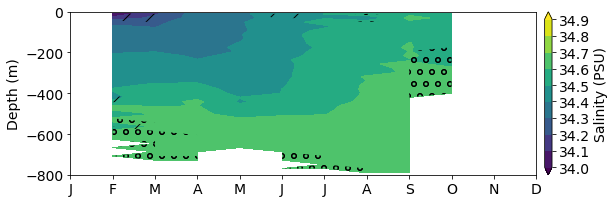

In [16]:
Weddellle75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&gline_le_75km], 
                                          years=[], depth_max=-800, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True, lonmin=-45, lonmax=-35,
                                         savename="./Images/seasonal/WSA1_sal.png", wd=10, ht=3)

In [17]:
Weddell_years = [2007, 2008, 2009, 2011, 2014, 2017]
WSA1_area = topView.find_area(dfmg[Weddell & gline_le_75km], m, years=Weddell_years)

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: UserWarning: Warning: converting a masked element to nan.
  area[j] = cell_size_x * cell_size_y * number_of_cells


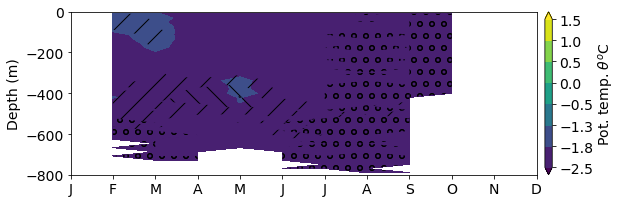

In [76]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell & gline_le_75km], 
                                          years=[], depth_max=-800, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/WSA1_CT.png", wd=10, ht=3)

In [19]:
np.nanmean(WSA1_area)

3739.5358240697569

1306.7400026 [-336.6944785] [ 159.28298519]


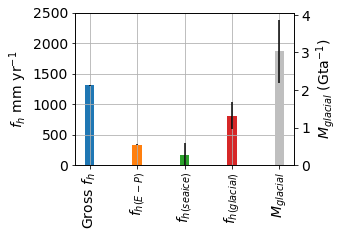

[ 223.74823866]


array([ 810.76253891])

In [22]:
pltfh.print_climatological_fh(Weddellle75_fh_m, np.nanmean(WSA1_area), verbose=True, 
                              plot=True, save=True, 
                savename='./Images/freshwaterFluxes/WSA1.png', wd=5, ht=3.5)

In [1]:
CDle75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[CDP&gline_le_75km], 
                                          years=[], depth_max=-800, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True, lonmin=-45, lonmax=-35,
                                         savename="./Images/seasonal/CDA1_sal.png", wd=10, ht=3)

NameError: name 'profile2dTime' is not defined

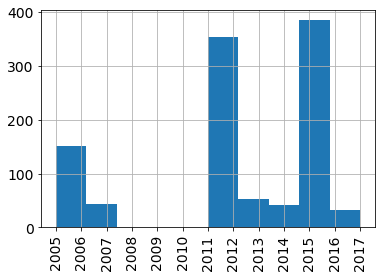

In [35]:
dfmg[CDP & gline_le_75km].loc[dfmg[CDP & gline_le_75km].groupby("PROFILE_NUMBER").head(1).index, "JULD"].dt.year.hist()
plt.xticks(np.arange(2005, 2018,1), rotation=90 )
plt.show()

In [36]:
CDP_years = [2005, 2011, 2012, 2015]
CDPA1_area = topView.find_area(dfmg[CDP & gline_le_75km], m, years=CDP_years)

3322.98170162 [-325.38031043] [ 213.63050401]


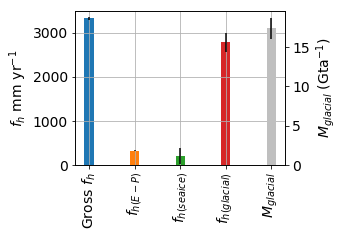

[ 215.5070859]


array([ 2783.97088718])

In [38]:
pltfh.print_climatological_fh(CDle75_fh_m, np.nanmean(CDPA1_area), verbose=True, 
                              plot=True, save=True, ymax=3500,
                savename='./Images/freshwaterFluxes/CDA1.png', wd=5, ht=3.5)

-54 -20 -78 -70


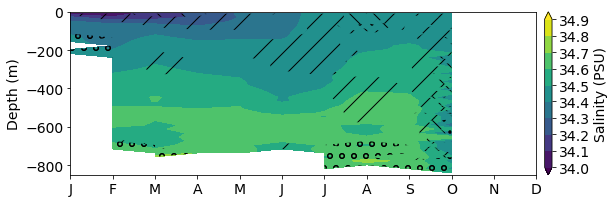

In [24]:
WeddellX75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[], depth_max=-850, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/WSA2_sal.png", wd= 10, ht=3)

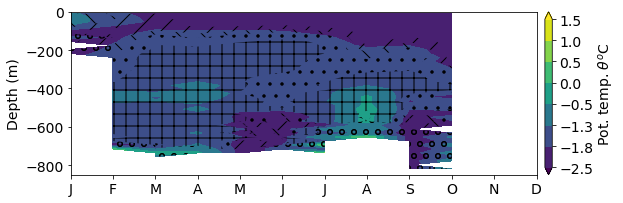

In [79]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell & ~gline_le_75km], 
                                          years=[], depth_max=-850, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/WSA2_CT.png", wd=10, ht=3)

In [ ]:
WeddellX75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[], depth_max=-850, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/WSA2_sal.png", wd= 10, ht=3)

2007


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2009
2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:185: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0747756180677 0.355029407441


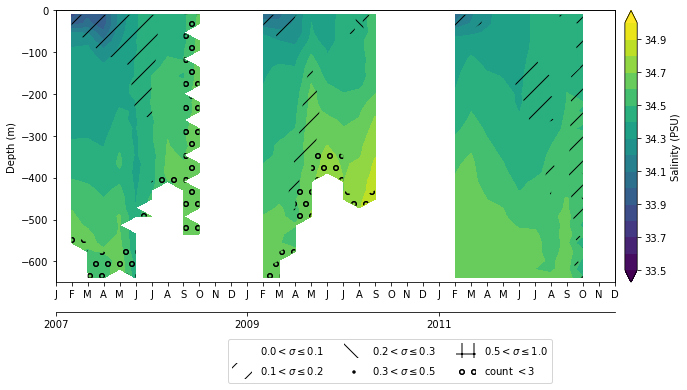

In [73]:
WeddellX75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True, type=0,
                                         savename="./Images/seasonal/WeddellSal_XGLle75km_disc.png", wd= 4*3)

In [80]:
WSA2_area

array([  57292.88842759,     999.87588879,   46794.19159531,
        184177.13871488,   31296.11531909,   26796.67381954])

894.439639251 [-336.08268103] [ 122.03966032]


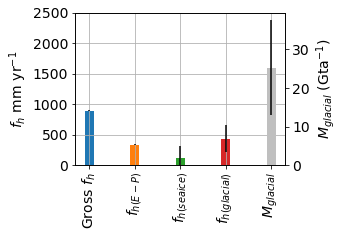

[ 213.57758955]


array([ 436.3172979])

In [108]:
pltfh.print_climatological_fh(WeddellX75_fh_m, np.average(WSA2_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/WSA2.png', wd=5, ht=3.5)

2007 1895.17074984 -234.484280123 97.8551205426
2009 1156.62892675 -199.147410772 112.392135469
2011 855.358981712 -95.647955378 98.9149327601


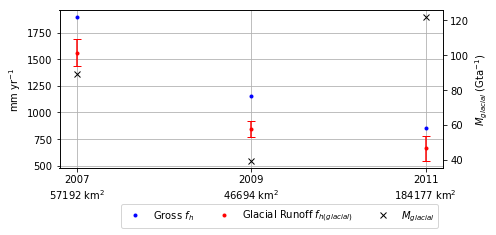

[ 124.73390566   71.85888756  114.85431968]


array([ 1562.83134917,   845.08938051,   660.79609357])

In [74]:
pltfh.print_yearly_fh(WeddellX75_fh_m, [2007, 2009, 2011], area_Weddell_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Weddell_X_le75_mass.png', wd=7)

In [488]:
100 * 1e9 * 1e3 * 1e-12

100.0

In [50]:
dfmg.loc[Ross, 'LONGITUDE'].min()

-179.9716

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  #legend([plot1], "title", prop=fontP)


0.354475588333 1.55549552656


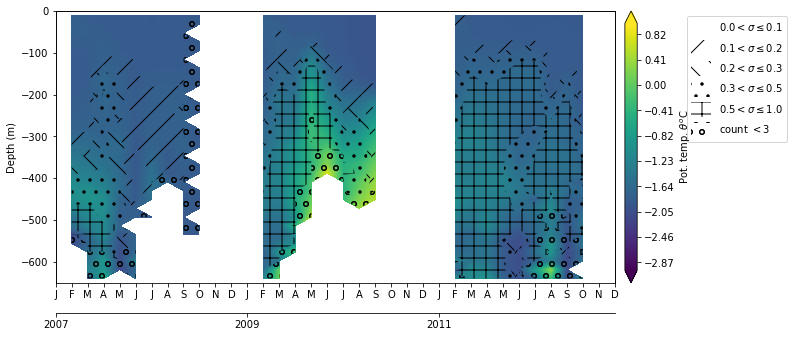

In [168]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(-3, 1.01, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellCT_XGLle75km.png", wd= 4*3)

70 74 -69 -67


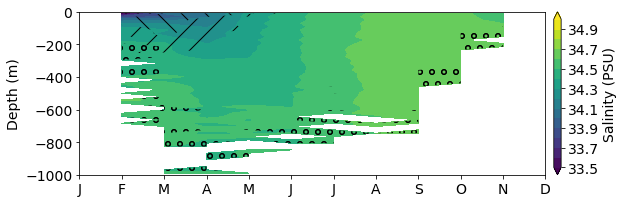

In [82]:
WPB_A1_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[WPB &gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/WPBA1_sal.png", wd=10, ht=3)

70 74 -69 -65


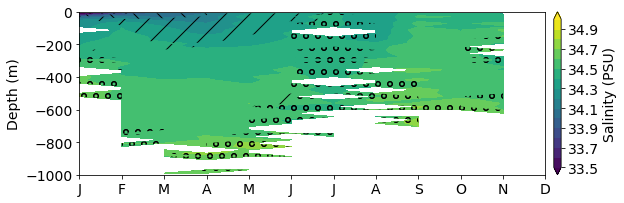

In [115]:
WPB_A2_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[WPB & ~gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/WPBA2_sal.png", wd=10, ht=3)

75 81 -69 -67


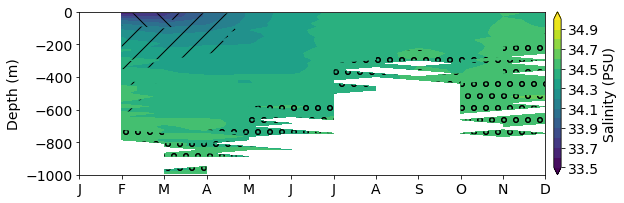

In [83]:
EPB_A1_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[EPB &gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/EPBA1_sal.png", wd=10, ht=3)

75 81 -69 -65


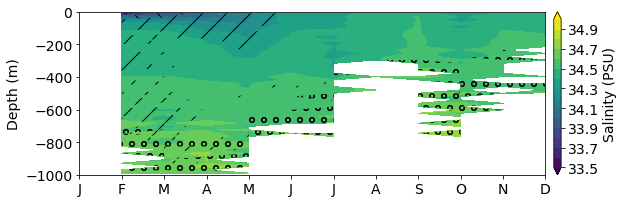

In [113]:
EPB_A2_fh, dl = profile2dTime.plot_sal_contours_with_time(dfmg[EPB & ~gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True,
                                         savename="./Images/seasonal/EPBA2_sal.png", wd=10, ht=3)

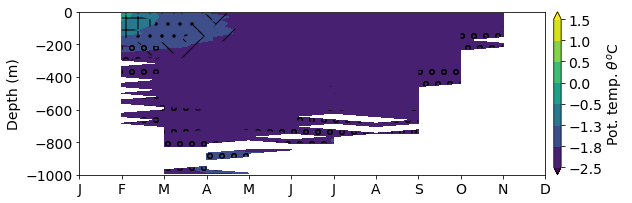

In [84]:
profile2dTime.plot_CT_contours_with_time(dfmg[WPB & gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/WPBA1_CT.png", wd=10, ht=3)

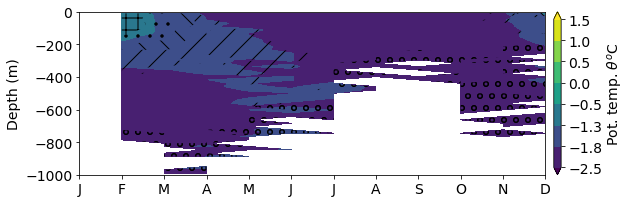

In [85]:
profile2dTime.plot_CT_contours_with_time(dfmg[EPB & gline_le_75km], 
                                          years=[], depth_max=-1000, zbin=20, 
                                          levs=thetarange, save=True, clim=True,
                                         savename="./Images/seasonal/EPBA1_CT.png", wd=10, ht=3)

2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2012
2013
2015


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:185: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0646220133027 0.326079455653


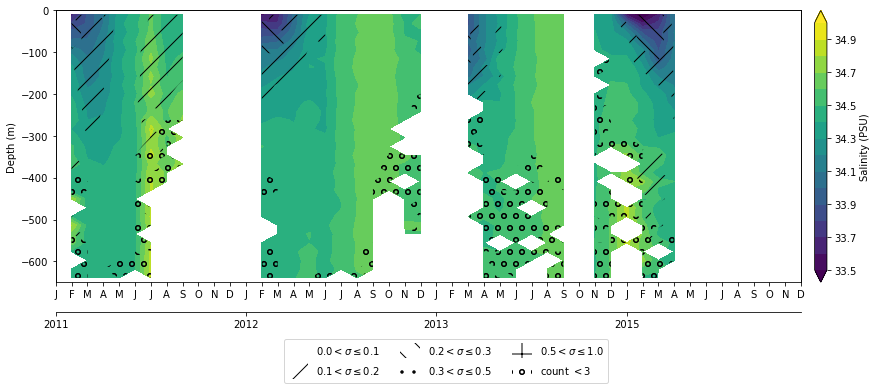

In [75]:
Prydzle75km_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True, type=0,
                                         savename="./Images/seasonal/PrydzSalGLle75km_disc.png", wd=4*4)

2120.4684293 [-300.39358802] [ 109.18106385]


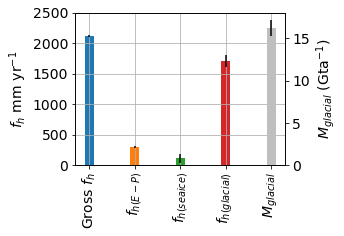

[ 101.20853257]


array([ 1710.89377742])

In [111]:
pltfh.print_climatological_fh(EPB_A1_fh, np.nanmean(EPBA1_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/EPBA1.png', wd=5, ht=3.5)

1610.68100645 [-306.06495087] [ 118.51995478]


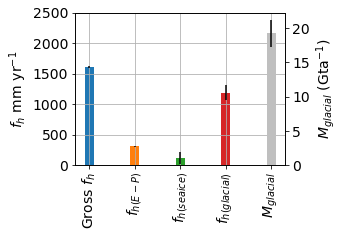

[ 122.23118157]


array([ 1186.09610081])

In [114]:
pltfh.print_climatological_fh(EPB_A2_fh, np.nanmean(EPBA2_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/EPBA2.png', wd=5, ht=3.5)

2401.35197799 [-248.48595763] [ 87.17407259]


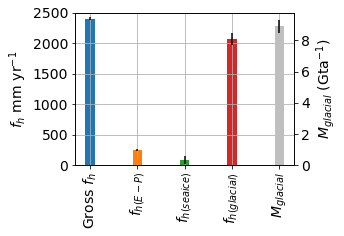

[ 96.38860546]


array([ 2065.69194777])

In [112]:
pltfh.print_climatological_fh(WPB_A1_fh, np.average(WPBA1_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/WPBA1.png', wd=5, ht=3.5)

1799.17188833 [-240.55668544] [ 100.08996555]


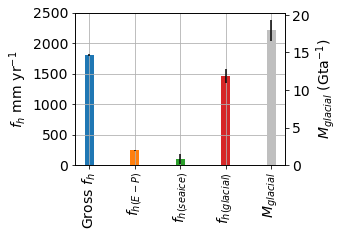

[ 113.19878223]


array([ 1458.52523734])

In [116]:
pltfh.print_climatological_fh(WPB_A2_fh, np.average(WPBA2_area), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/WPBA2.png', wd=5, ht=3.5)

2011 2691.49301373 -183.242777436 80.262508396
2012 2798.86369285 -244.371288103 83.940248772
2013 2670.23096555 -319.882642371 117.709106047


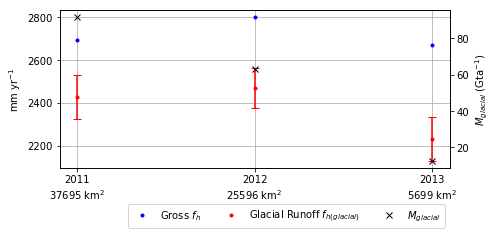

[ 103.26699694   92.88560468  102.02735046]


array([ 2427.9877279 ,  2470.55215598,  2232.63921713])

In [76]:
pltfh.print_yearly_fh(Prydzle75km_fh_m, [2011, 2012, 2013], area_Prydz_le75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Prydz_le75_mass.png', wd=7)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0856536790666 0.595948069774


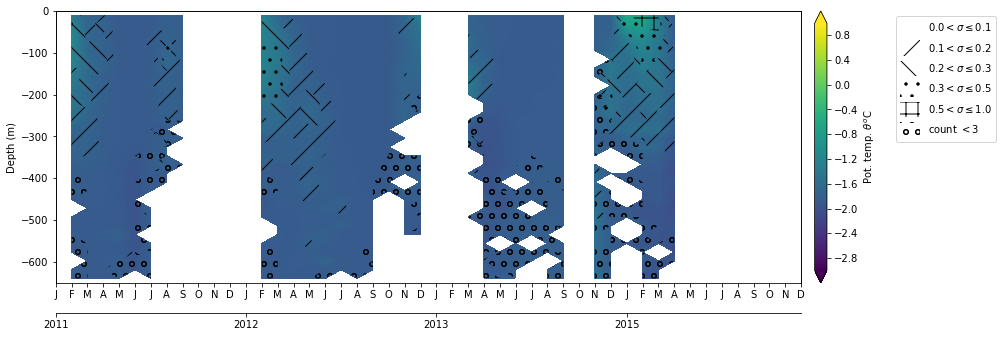

In [180]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=thetarange, save=True,
                                         savename="./Images/seasonal/PrydzCTGLle75km.png", wd=4*4)

In [242]:
len(np.arange(-3, 1.01, 0.01))

401

60 79 -69 -65


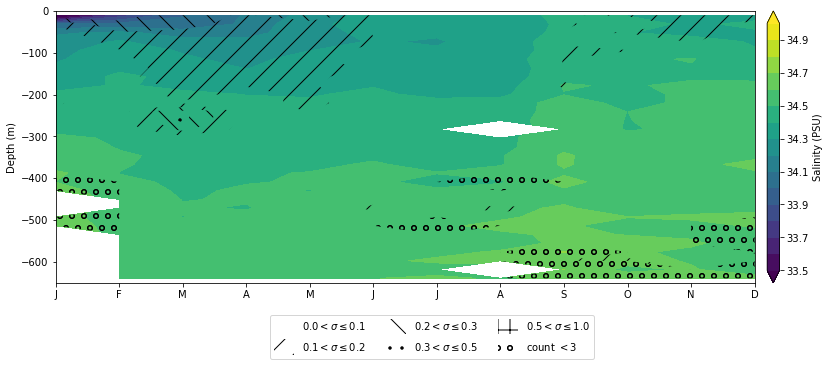

In [322]:
Prydz_X75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True, type=0, clim=True, wd=15,
                                         savename="./Images/seasonal/PrydzSal_XGLle75km_disc_clim.png")

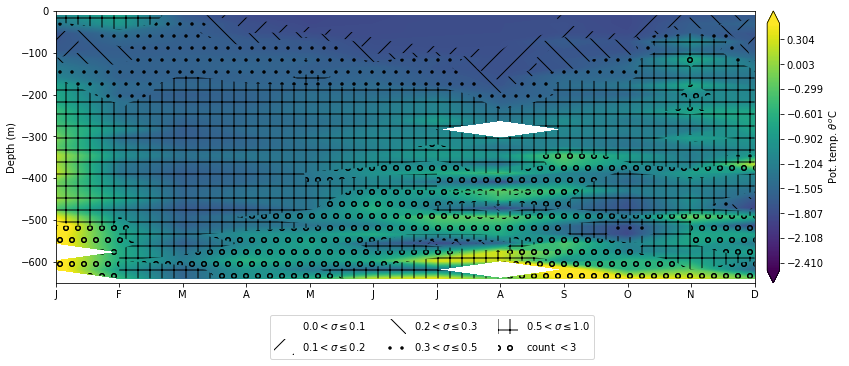

In [418]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz & ~gline_le_75km], 
                                          years=WeddellYears, depth_max=-650, zbin=20, 
                                          levs=thetarange_X75, save=True, clim=True,
                                         savename="./Images/seasonal/PrydzCT_XGLle75km.png", wd=15)

2011


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:49: RuntimeWarning: Mean of empty slice
  E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/compute_EP_net.py:50: RuntimeWarning: Mean of empty slice
  E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month


2012
2013
2015


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:185: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.0736226848042 0.424216458011


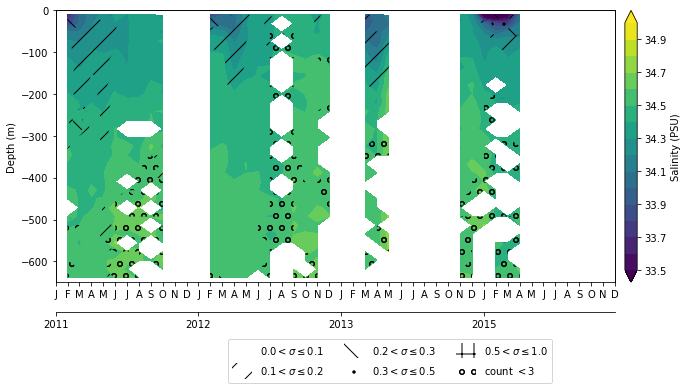

In [77]:
Prydz_X75_fh_m, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=salrange_disc, save=True, type=0,
                                         savename="./Images/seasonal/PrydzSal_XGLle75km_disc.png")

1605.70815033 [-274.13961735] [ 102.90532363]


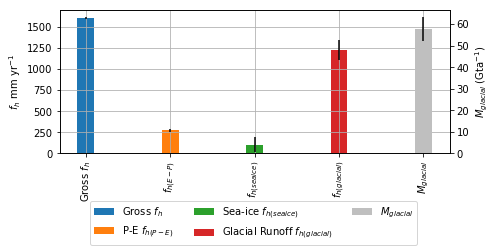

[ 120.19907898]


array([ 1228.66320936])

In [323]:
pltfh.print_climatological_fh(Prydz_X75_fh_m, np.average(area_Prydz_Xle75), verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Prydz_X_le75_mass_clim.png', wd=7)

2011 1177.12940377 -166.785710878 88.3434704386
2012 1465.27129458 -244.488600024 85.3846473394


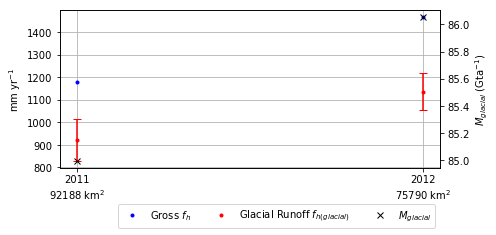

[ 91.83000248  81.25167667]


array([  922.00022245,  1135.39804722])

In [78]:
pltfh.print_yearly_fh(Prydz_X75_fh_m, [2011, 2012], area_Prydz_Xle75, verbose=True, plot=True, save=True, 
                savename='./Images/freshwaterFluxes/Prydz_X_le75_mass.png', wd=7)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:262: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]), np.max(conf_int[conf_int < 1e5]))


0.547563899799 1.63242107255


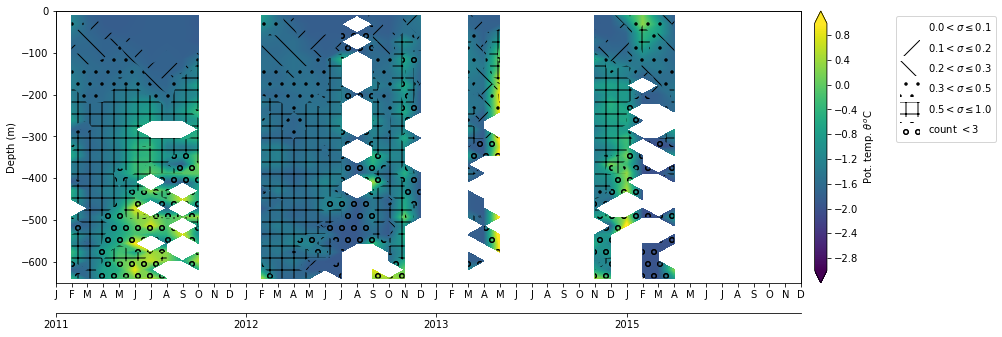

In [181]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=thetarange, save=True,
                                         savename="./Images/seasonal/PrydzCT_XGLle75km_disc.png", wd=4*4)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.530508036241


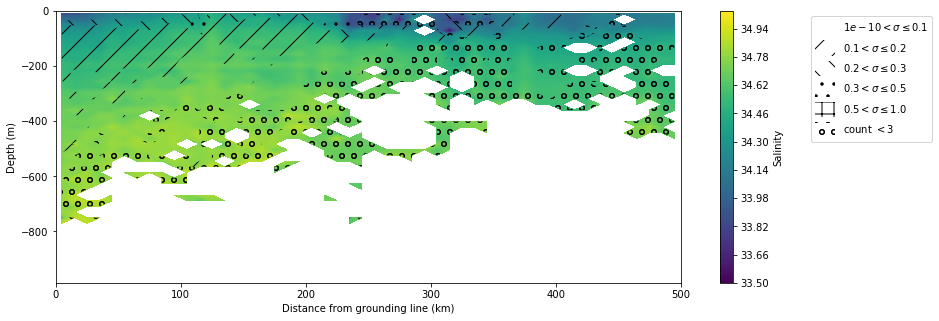

In [549]:
mask = Ross & sel_months(dfmg, [1,2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

In [551]:
dfmg.loc[dfmg.groupby('PROFILE_NUMBER').head(1).index].DENSITY_INSITU.mean()

1027.3747727524642

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.530508036241


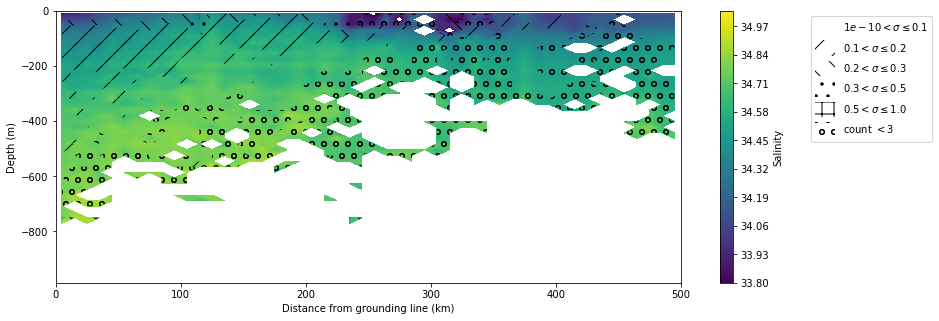

In [325]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=list(np.arange(33.8, 35.05, 0.01)))

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


4.34670318691


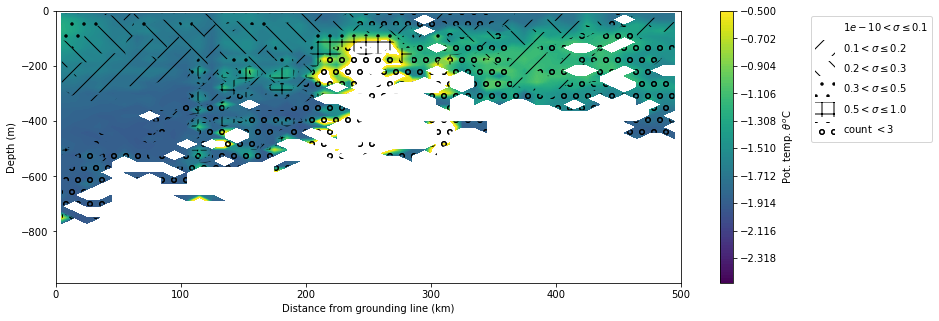

In [394]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_JFM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.614534421647


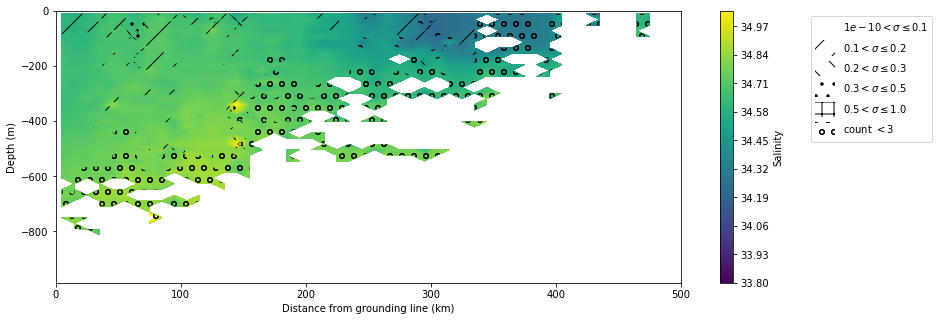

In [327]:
mask = Ross & sel_months(dfmg, [6,7,8])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJA.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.835200327413


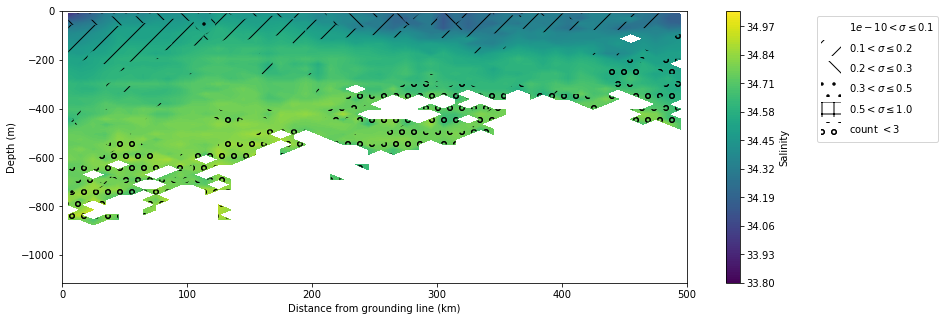

In [328]:
mask = Ross & sel_months(dfmg, [1,2,3,4,5])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFMAM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.641571789698


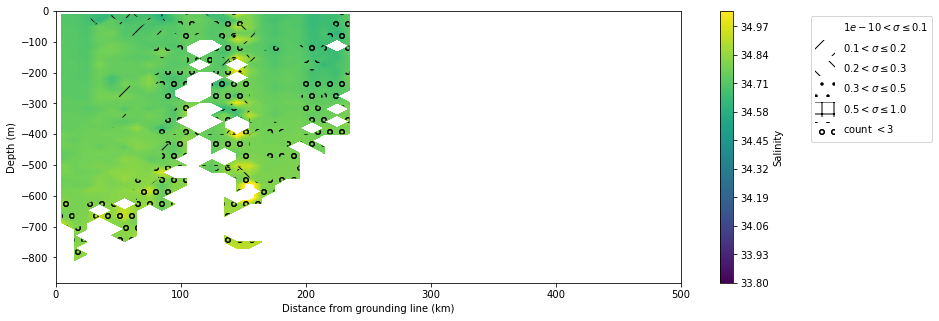

In [329]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.208345547077


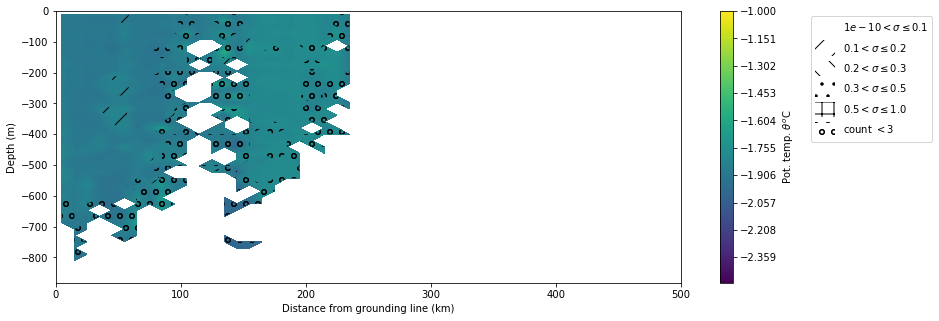

In [331]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=-1, nlevs=150)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.614534421647


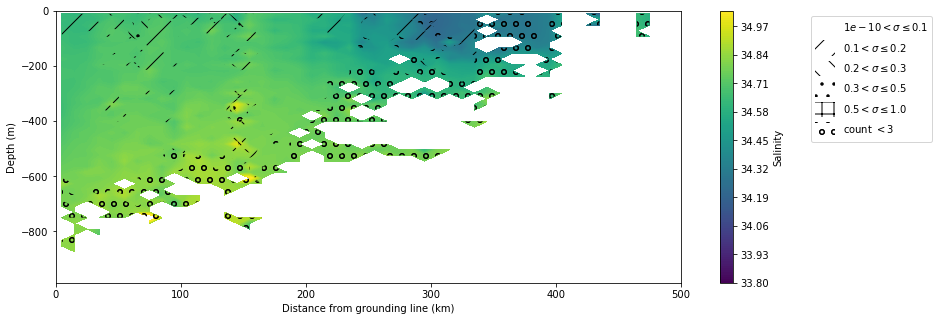

In [332]:
mask = Ross & sel_months(dfmg, [6,7,8,9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJASON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.235334717021


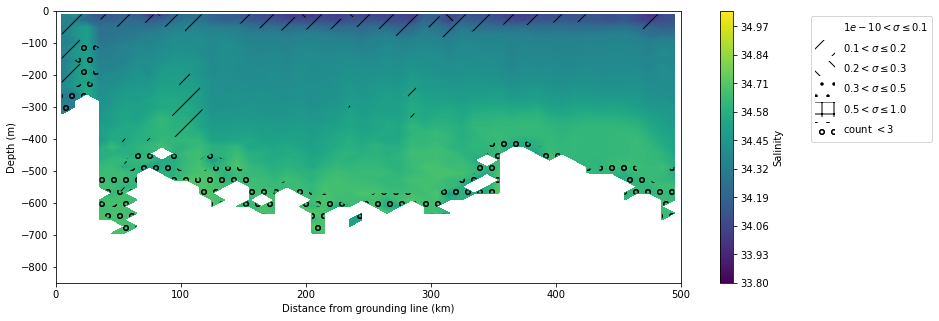

In [333]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, nlevs=9, levs=salrange)

In [123]:
np.linspace(-3, 1, 9)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


1.50399063187


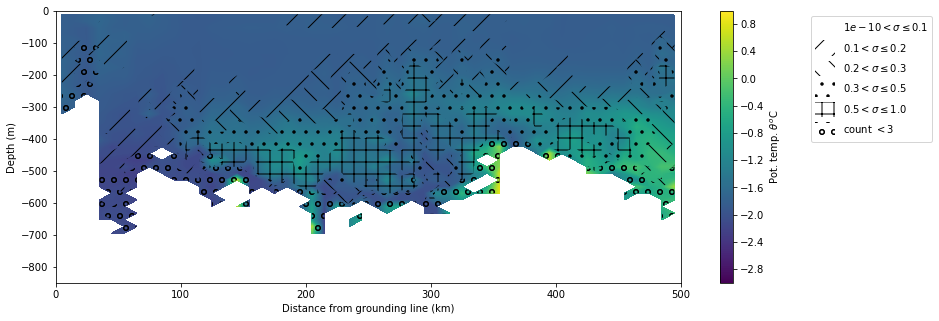

In [334]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.515398808624


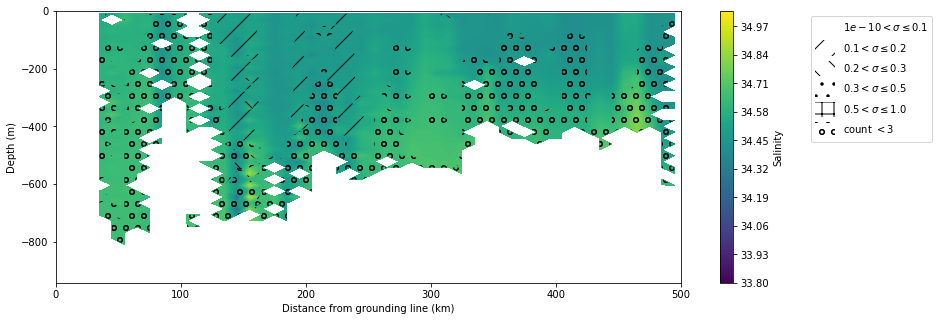

In [335]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=salrange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


1.35045721024


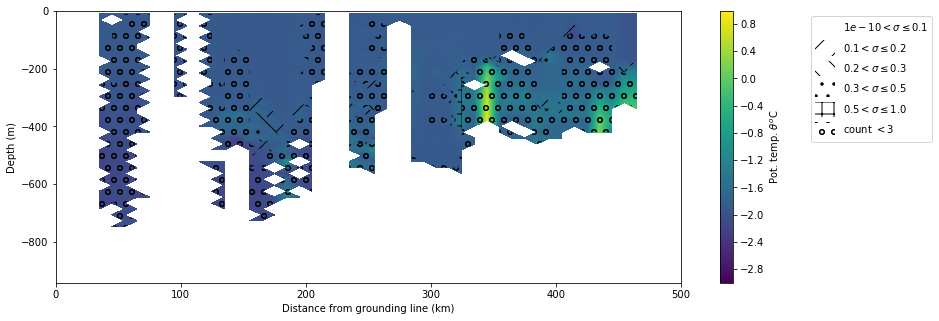

In [336]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=1, levs=thetarange)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.864809577408


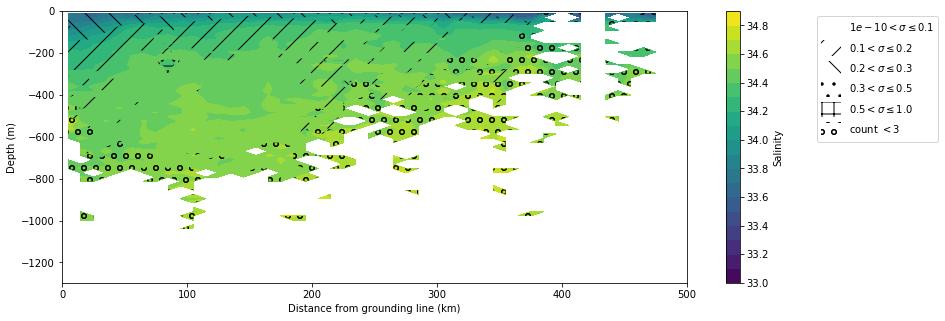

In [338]:
mask = Prydz & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Prydz_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, levs=list(np.arange(33,35,.1)))

In [139]:
x = np.arange(5)
y = np.arange(5)

z = np.random.randn(5, 5)

In [138]:
z.shape

(5, 5)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


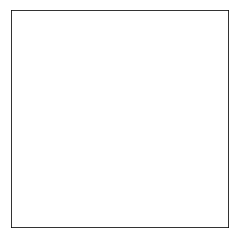

In [143]:
xx, yy = np.meshgrid(x, y)
m.contour(xx, yy, z)
plt.show()